In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:1')
print(device)

cuda:1


In [3]:
class Hyperparameter():
    def __init__(self):
        self.dict = {}
        self.dict['optimizer'] = {}
        self.dict['optimizer']['lr'] = [1e-4, 5.5e-6]
        self.dict['optimizer']['beta'] = [(0.9, 0.999), (0.9, 0.999)]
        self.dict['optimizer']['eps'] = [1e-7, 1e-7]
        self.dict['optimizer']['method'] = 'Adam'
    
        self.dict['epoch'] = [100, 50]
        self.dict['batch_size'] = 32
        self.dict['patience'] = 20
        self.dict['min_delta'] = 1e-4
        
        self.dict['training_data'] = {}
        self.dict['training_data']['path'] = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
        self.dict['training_data']['data'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy'
        self.dict['training_data']['label_1'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_45mradnewEmit_x25000.npy'
        self.dict['training_data']['label_2'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy'
        self.dict['training_data']['split'] = 0.8
        self.dict['training_data']['aperture'] = 45
        self.dict['training_data']['limit'] = 50
        
        self.dict['segmentation'] = {}
        self.dict['segmentation']['resize'] = (135, 135)
        self.dict['segmentation']['ratio'] = (0.97, 1.03)
        self.dict['segmentation']['scale'] = (0.9, 1.0)
        self.dict['segmentation']['normalize'] = None
        
        self.dict['architecture'] = {}
        self.dict['architecture']['dropout'] = 0.3
        self.dict['architecture']['linear_shape'] = [256]
        
        self.process = {}
        
        self.process['training'] = []
        self.process['validation'] = []
        
    def add_training_process(self, training_acc, validation_acc, epoch):
        if epoch == 0:
            self.process['training'].append([])
            self.process['validation'].append([])
        if torch.is_tensor(training_acc):
            training_acc = training_acc.cpu().detach().numpy()
        if torch.is_tensor(validation_acc):
            validation_acc = validation_acc.cpu().detach().numpy()
        self.process['training'][-1].append(training_acc)
        self.process['validation'][-1].append(validation_acc)
        return
    
    def save_result(self, path):
        with open(path + 'hyperparameter.pkl', 'wb') as f:
            pickle.dump(self.dict, f)
        with open(path + 'training_log.pkl', 'wb') as f:
            pickle.dump(self.process, f)

In [4]:
par = Hyperparameter()

In [5]:
# Customized CNN model
class Net(Module):   
    def __init__(self, pretrained = False, dropout = 0.3, linear_shape = 512):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv7 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv8 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv9 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv10 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv11 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv12 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv13 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.fc1 = nn.Linear(4 * 4 * 512, linear_shape)
        self.dropout = nn.Dropout(p = dropout)
#         self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(linear_shape, 1)
    
    def lock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = False
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
#         self.fc2.weight.requires_grad = True
#         self.fc2.bias.requires_grad = True
        self.fc3.weight.requires_grad = True
        self.fc3.bias.requires_grad = True
    
    def unlock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = True
            
    def load_pretrained(self):
        print("Loading weights and bias from VGG16.")
        vgg16 = torchvision.models.vgg16(pretrained = True)
        self.conv1.weight.data = vgg16.features[0].weight.data.to(device = device)
        self.conv1.bias.data = vgg16.features[0].bias.data.to(device = device)
        self.conv2.weight.data = vgg16.features[2].weight.data.to(device = device)
        self.conv2.bias.data = vgg16.features[2].bias.data.to(device = device)
        self.conv3.weight.data = vgg16.features[5].weight.data.to(device = device)
        self.conv3.bias.data = vgg16.features[5].bias.data.to(device = device)
        self.conv4.weight.data = vgg16.features[7].weight.data.to(device = device)
        self.conv4.bias.data = vgg16.features[7].bias.data.to(device = device)
        self.conv5.weight.data = vgg16.features[10].weight.data.to(device = device)
        self.conv5.bias.data = vgg16.features[10].bias.data.to(device = device)
        self.conv6.weight.data = vgg16.features[12].weight.data.to(device = device)
        self.conv6.bias.data = vgg16.features[12].bias.data.to(device = device)
        self.conv7.weight.data = vgg16.features[14].weight.data.to(device = device)
        self.conv7.bias.data = vgg16.features[14].bias.data.to(device = device)
        self.conv8.weight.data = vgg16.features[17].weight.data.to(device = device)
        self.conv8.bias.data = vgg16.features[17].bias.data.to(device = device)
        self.conv9.weight.data = vgg16.features[19].weight.data.to(device = device)
        self.conv9.bias.data = vgg16.features[19].bias.data.to(device = device)
        self.conv10.weight.data = vgg16.features[21].weight.data.to(device = device)
        self.conv10.bias.data = vgg16.features[21].bias.data.to(device = device)
        self.conv11.weight.data = vgg16.features[24].weight.data.to(device = device)
        self.conv11.bias.data = vgg16.features[24].bias.data.to(device = device)
        self.conv12.weight.data = vgg16.features[26].weight.data.to(device = device)
        self.conv12.bias.data = vgg16.features[26].bias.data.to(device = device)
        self.conv13.weight.data = vgg16.features[28].weight.data.to(device = device)
        self.conv13.bias.data = vgg16.features[28].bias.data.to(device = device)
    
    # Defining the forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [7]:
input_path = par.dict['training_data']['path']
train_data = np.load(input_path + par.dict['training_data']['data'])
print(train_data.shape)

train_label = np.load(input_path + par.dict['training_data']['label_1'])
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + par.dict['training_data']['label_2'])
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25002, 128, 128)
(25002,)
(25002,)


In [8]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [ ]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [ ]:
if par.dict['training_data']['aperture'] != 0:
    aperture_mask = aperture_generator(128, par.dict['training_data']['limit'], 
                                       par.dict['training_data']['aperture'])

In [9]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img * 255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [10]:
transform = transforms.Compose(
        [
            transforms.Resize(par.dict['segmentation']['resize']),
            transforms.RandomResizedCrop((128, 128), scale = par.dict['segmentation']['scale'], ratio = par.dict['segmentation']['ratio']),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [11]:
# training hyperparameters
train_CNN = False
batch_size = par.dict['batch_size']
shuffle = True
pin_memory = True
num_workers = 1

In [12]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

n_train = int(len(train_data) * par.dict['training_data']['split'])
n_val = len(train_data) - n_train
train_set, validation_set = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

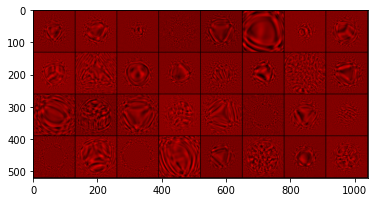

In [14]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.colorbar()
    plt.show()
    
imshow(torchvision.utils.make_grid(images))

In [15]:
# Call the CNN model and start training
model = Net(dropout = 0.3, linear_shape = par.dict['architecture']['linear_shape'][0]).to(device)
model.load_pretrained()
model.lock_base()
criterion = nn.MSELoss(reduction = 'mean')

Loading weights and bias from VGG16.


In [16]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()
    
    # define two lists to save truth and predictions, for the plot only.
    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y) * y.shape[0]
            counter += y.shape[0]
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
#     print( f"Got accuracy {float(sum_MSE)/float(counter):.6f}" )   
    return f"{float(sum_MSE)/float(counter):.6f}"
    
#     model.train()

In [17]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience = 5, min_delta = 0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [18]:
def train():
    early_stopping = EarlyStopping(patience = par.dict['patience'], min_delta = par.dict['min_delta'])
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(float(val_acc))
            if early_stopping.early_stop:
                par.add_training_process(acc_loss / counter , val_acc, epoch)
                break
                
        acc_loss = 0
        counter = 0
        
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            acc_loss += loss * labels.shape[0]
            counter += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())
        
        par.add_training_process(acc_loss / counter , val_acc, epoch)
        print(f"Training acc: {float(acc_loss) / float(counter):.6f}, Validation accuracy {float(val_acc):.6f}")

  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


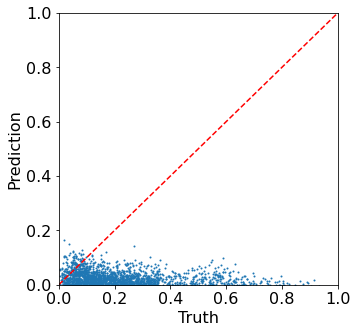

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.140483]

Got accuracy 0.140483


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [0/100]: 100%|███████████▉| 625/626 [00:43<00:00, 18.59it/s, loss=0.00415]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


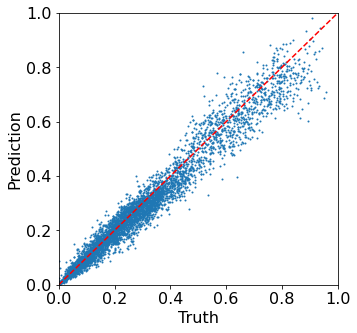

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001953]

Got accuracy 0.001953


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [2/100]: 100%|███████████▉| 625/626 [00:43<00:00, 18.11it/s, loss=0.00341]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


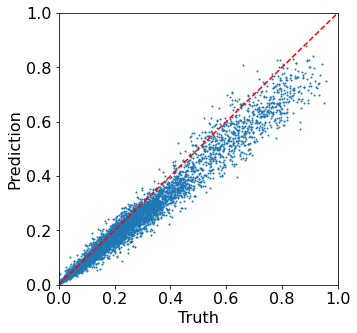

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.003414]

Got accuracy 0.003414
INFO: Early stopping counter 1 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [4/100]: 100%|███████████▉| 625/626 [00:45<00:00, 17.10it/s, loss=0.00317]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


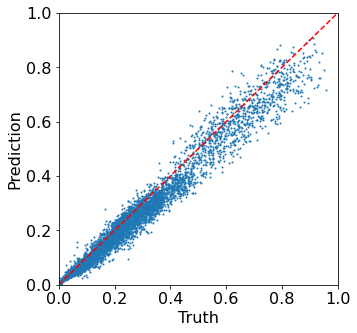

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.002201]

Got accuracy 0.002201
INFO: Early stopping counter 2 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [6/100]: 100%|███████████▉| 624/626 [00:46<00:00, 16.79it/s, loss=0.00395]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


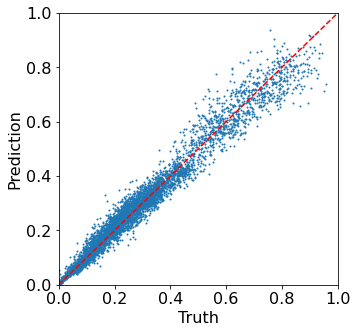

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001460]

Got accuracy 0.001460


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [8/100]: 100%|███████████▉| 625/626 [00:44<00:00, 17.62it/s, loss=0.00232]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


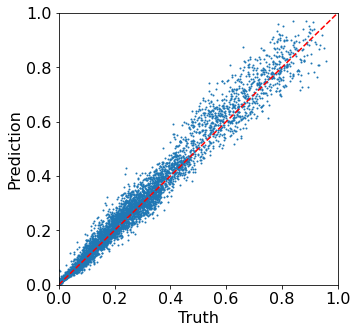

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001706]

Got accuracy 0.001706
INFO: Early stopping counter 3 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [10/100]: 100%|███████████▉| 625/626 [00:44<00:00, 16.22it/s, loss=0.0027]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


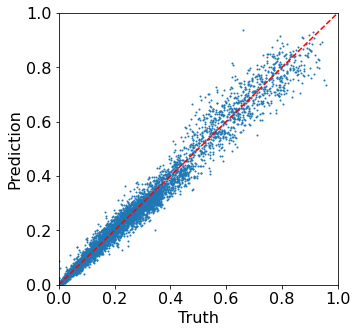

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001291]

Got accuracy 0.001291


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [12/100]: 100%|██████████▉| 625/626 [00:44<00:00, 17.97it/s, loss=0.00128]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


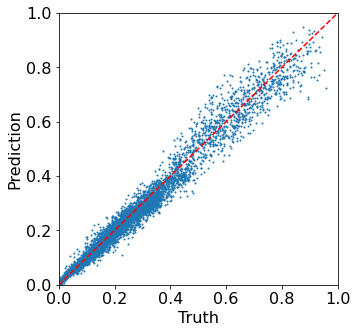

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001322]

Got accuracy 0.001322
INFO: Early stopping counter 4 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [14/100]: 100%|██████████▉| 625/626 [00:44<00:00, 18.12it/s, loss=0.00121]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


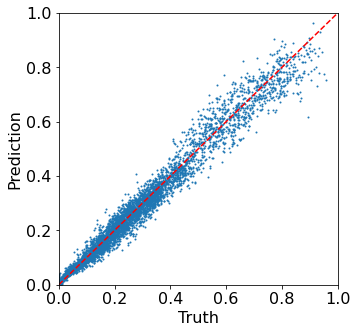

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001276]

Got accuracy 0.001276
INFO: Early stopping counter 5 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [16/100]: 100%|██████████▉| 625/626 [00:43<00:00, 17.97it/s, loss=0.00331]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


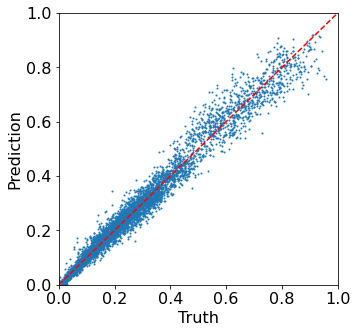

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001243]

Got accuracy 0.001243
INFO: Early stopping counter 6 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [18/100]: 100%|██████████▉| 625/626 [00:44<00:00, 17.40it/s, loss=0.00305]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


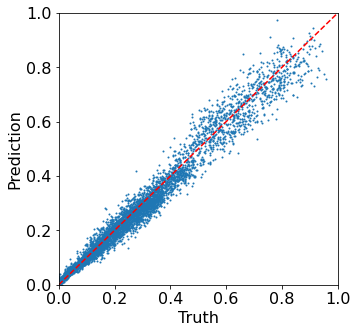

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001326]

Got accuracy 0.001326
INFO: Early stopping counter 7 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/100]: 100%|██████████▉| 625/626 [00:44<00:00, 16.69it/s, loss=0.00317]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


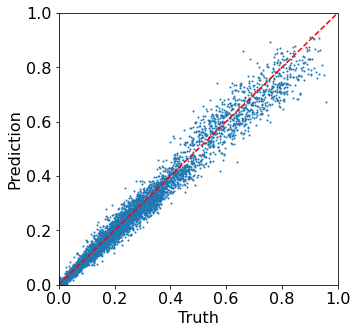

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001278]

Got accuracy 0.001278
INFO: Early stopping counter 8 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [22/100]: 100%|██████████▉| 625/626 [00:45<00:00, 17.10it/s, loss=0.00057]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


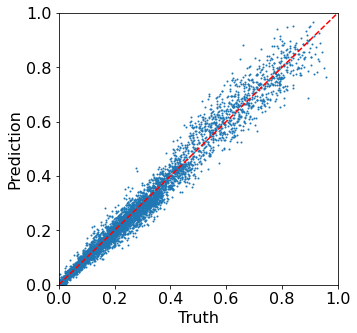

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001256]

Got accuracy 0.001256
INFO: Early stopping counter 9 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/100]: 100%|███████████▉| 625/626 [00:45<00:00, 16.96it/s, loss=0.0018]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


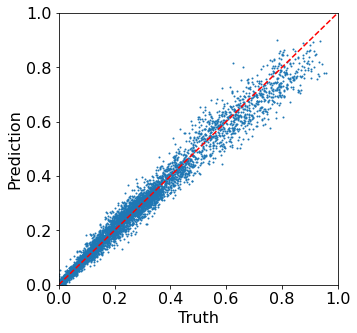

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001240]

Got accuracy 0.001240
INFO: Early stopping counter 10 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [26/100]: 100%|██████████▉| 625/626 [00:45<00:00, 16.28it/s, loss=0.00125]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


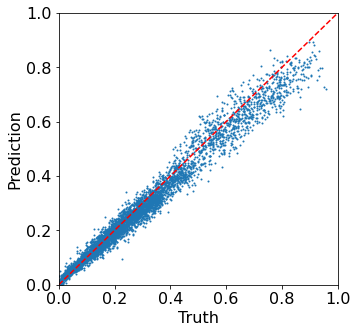

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001366]

Got accuracy 0.001366
INFO: Early stopping counter 11 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/100]: 100%|██████████▉| 625/626 [00:45<00:00, 16.45it/s, loss=0.00113]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


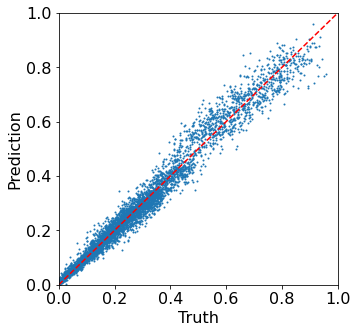

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001171]

Got accuracy 0.001171


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/100]: 100%|██████████▉| 624/626 [00:45<00:00, 17.46it/s, loss=0.00317]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


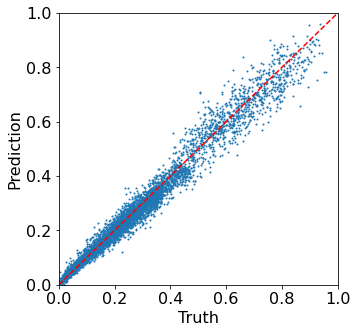

  0%|                                 | 0/626 [00:08<?, ?it/s, val_acc=0.001179]

Got accuracy 0.001179
INFO: Early stopping counter 12 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/100]: 100%|██████████▉| 625/626 [00:46<00:00, 15.67it/s, loss=0.00143]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


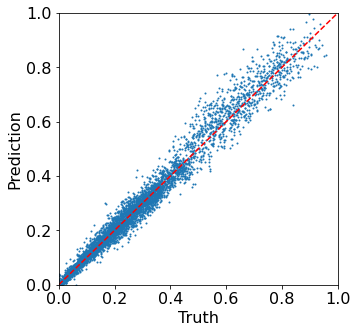

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001203]

Got accuracy 0.001203
INFO: Early stopping counter 13 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/100]: 100%|██████████▉| 625/626 [00:50<00:00, 15.57it/s, loss=0.00354]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


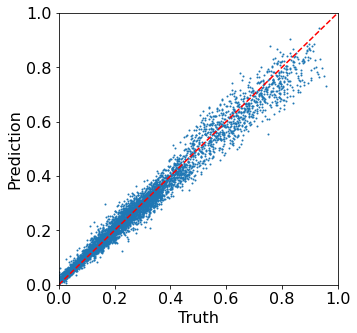

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001177]

Got accuracy 0.001177
INFO: Early stopping counter 14 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [36/100]: 100%|██████████▉| 625/626 [00:50<00:00, 15.23it/s, loss=0.00204]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


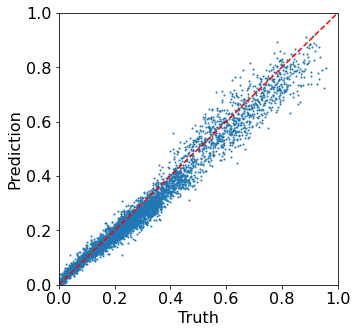

  0%|                                 | 0/626 [00:10<?, ?it/s, val_acc=0.001596]

Got accuracy 0.001596
INFO: Early stopping counter 15 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [38/100]: 100%|██████████▉| 625/626 [00:51<00:00, 15.26it/s, loss=0.00127]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


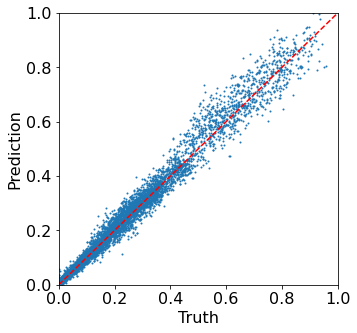

  0%|                                 | 0/626 [00:10<?, ?it/s, val_acc=0.001259]

Got accuracy 0.001259
INFO: Early stopping counter 16 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [40/100]: 100%|██████████▉| 625/626 [00:50<00:00, 15.48it/s, loss=0.00252]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


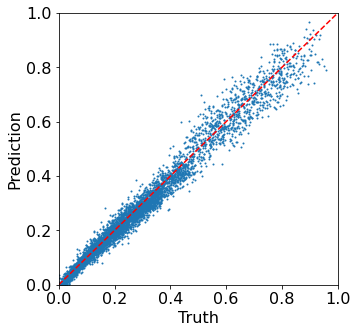

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001106]

Got accuracy 0.001106
INFO: Early stopping counter 17 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [42/100]: 100%|█████████▉| 625/626 [00:50<00:00, 15.91it/s, loss=0.000654]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


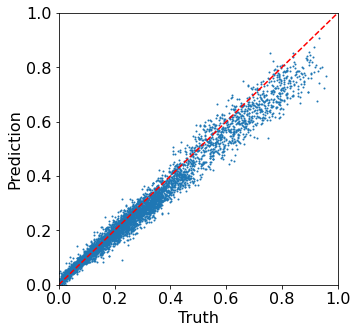

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001628]

Got accuracy 0.001628
INFO: Early stopping counter 18 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [44/100]: 100%|█████████▉| 625/626 [00:50<00:00, 15.53it/s, loss=0.000833]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


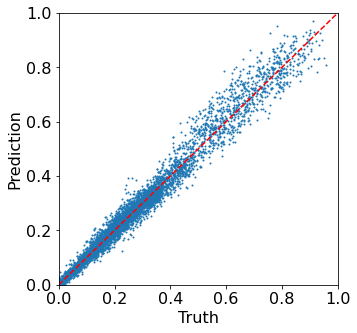

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001156]

Got accuracy 0.001156
INFO: Early stopping counter 19 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [46/100]: 100%|███████████▉| 625/626 [00:50<00:00, 15.52it/s, loss=0.0011]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


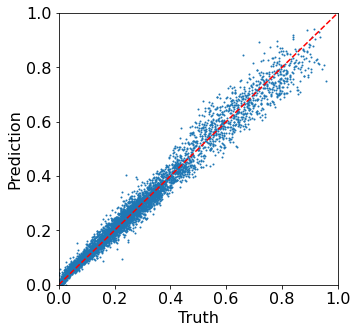

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001083]

Got accuracy 0.001083
INFO: Early stopping counter 20 of 20
INFO: Early stopping


In [19]:
stage = 0
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


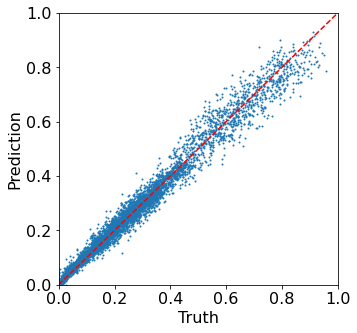

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001076]

Got accuracy 0.001076


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [0/50]: 100%|████████████▉| 625/626 [02:44<00:00,  4.06it/s, loss=0.00125]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


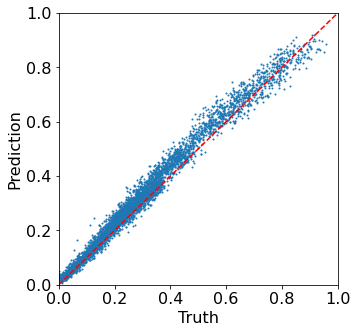

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.001226]

Got accuracy 0.001226
INFO: Early stopping counter 1 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [2/50]: 100%|███████████▉| 625/626 [02:43<00:00,  4.11it/s, loss=0.000636]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


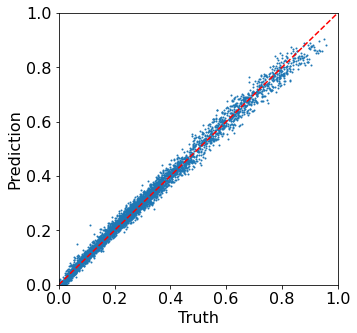

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000366]

Got accuracy 0.000366


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [4/50]: 100%|███████████▉| 625/626 [02:43<00:00,  4.01it/s, loss=0.000387]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


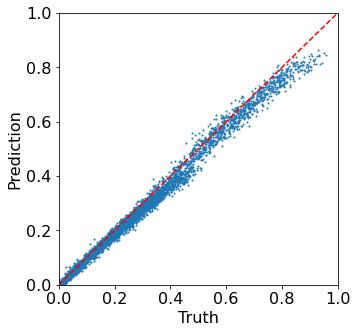

  0%|                                 | 0/626 [00:10<?, ?it/s, val_acc=0.000664]

Got accuracy 0.000664
INFO: Early stopping counter 2 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [6/50]: 100%|███████████▉| 625/626 [02:43<00:00,  4.11it/s, loss=0.000324]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


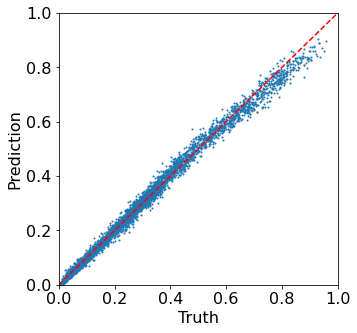

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000336]

Got accuracy 0.000336
INFO: Early stopping counter 3 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [8/50]: 100%|███████████▉| 625/626 [02:38<00:00,  4.21it/s, loss=0.000807]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


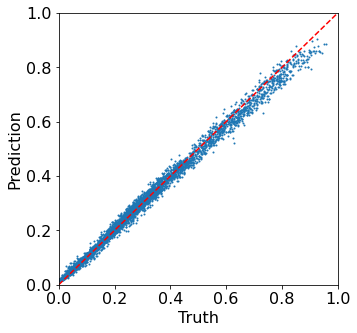

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000323]

Got accuracy 0.000323
INFO: Early stopping counter 4 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [10/50]: 100%|██████████▉| 625/626 [02:37<00:00,  4.22it/s, loss=0.000237]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


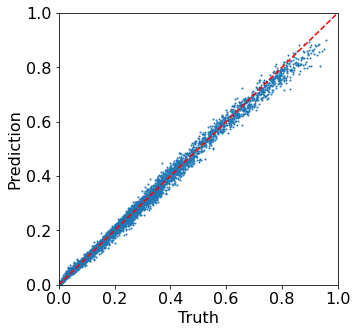

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000282]

Got accuracy 0.000282
INFO: Early stopping counter 5 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [12/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.24it/s, loss=0.000579]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


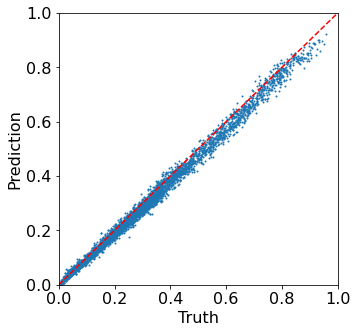

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000455]

Got accuracy 0.000455
INFO: Early stopping counter 6 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [14/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.18it/s, loss=0.000311]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


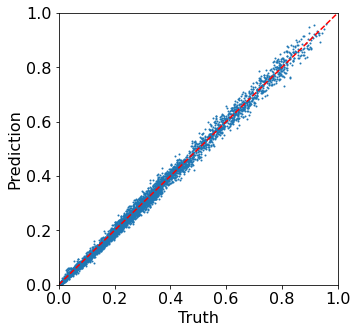

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000238]

Got accuracy 0.000238


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [16/50]: 100%|███████████▉| 625/626 [02:37<00:00,  4.25it/s, loss=0.00041]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


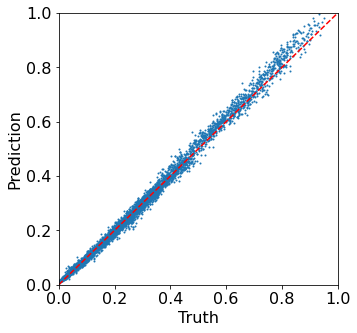

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000298]

Got accuracy 0.000298
INFO: Early stopping counter 7 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [18/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.21it/s, loss=0.000603]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


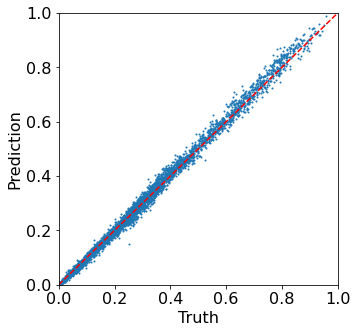

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000246]

Got accuracy 0.000246
INFO: Early stopping counter 8 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.20it/s, loss=0.000549]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


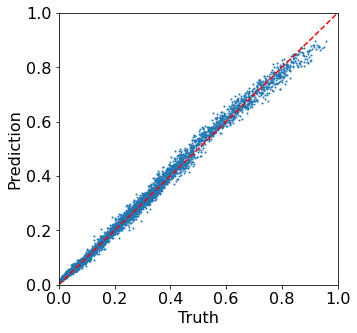

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000286]

Got accuracy 0.000286
INFO: Early stopping counter 9 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [22/50]: 100%|██████████▉| 625/626 [02:37<00:00,  4.26it/s, loss=0.000511]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


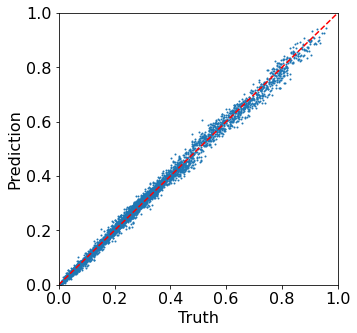

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000221]

Got accuracy 0.000221
INFO: Early stopping counter 10 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.17it/s, loss=0.000436]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


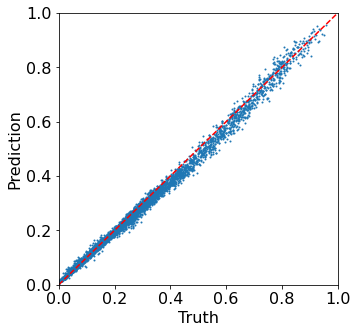

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000347]

Got accuracy 0.000347
INFO: Early stopping counter 11 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [26/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.20it/s, loss=0.000327]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


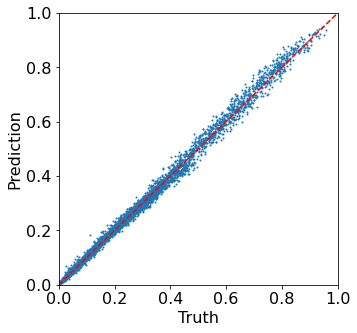

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000241]

Got accuracy 0.000241
INFO: Early stopping counter 12 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.21it/s, loss=0.000255]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


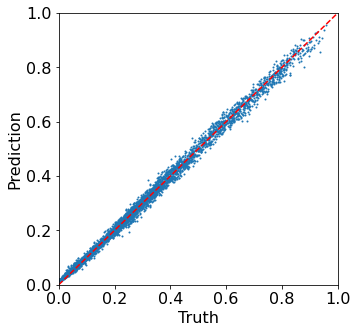

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000192]

Got accuracy 0.000192
INFO: Early stopping counter 13 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.19it/s, loss=0.000463]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


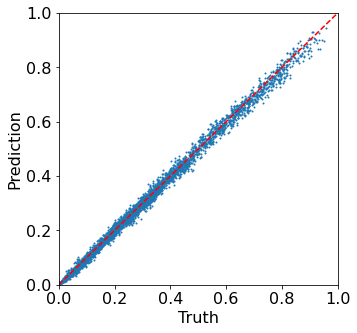

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000187]

Got accuracy 0.000187
INFO: Early stopping counter 14 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.22it/s, loss=0.000117]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


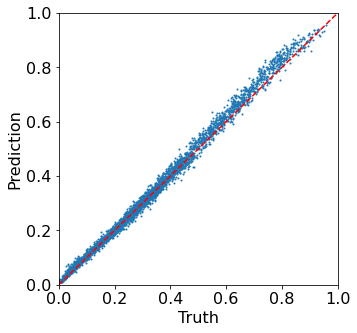

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000306]

Got accuracy 0.000306
INFO: Early stopping counter 15 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.19it/s, loss=0.000277]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


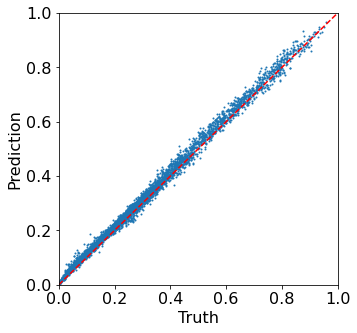

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000394]

Got accuracy 0.000394
INFO: Early stopping counter 16 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [36/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.21it/s, loss=0.000389]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


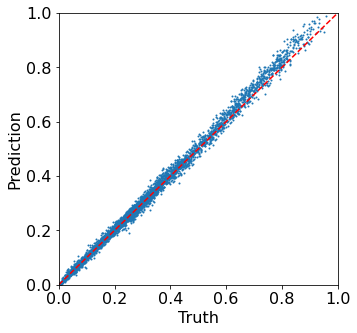

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000264]

Got accuracy 0.000264
INFO: Early stopping counter 17 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [38/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.20it/s, loss=0.000482]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


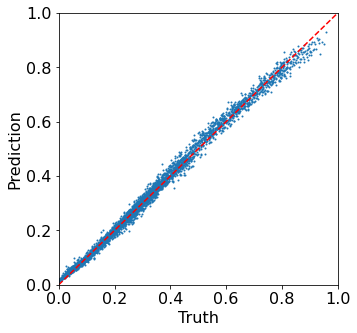

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000220]

Got accuracy 0.000220
INFO: Early stopping counter 18 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [40/50]: 100%|██████████▉| 625/626 [02:38<00:00,  4.22it/s, loss=0.000327]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


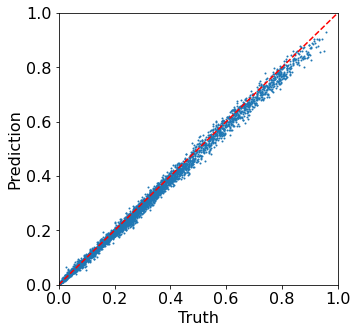

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000257]

Got accuracy 0.000257
INFO: Early stopping counter 19 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [42/50]: 100%|██████████▉| 625/626 [02:37<00:00,  4.19it/s, loss=0.000443]/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


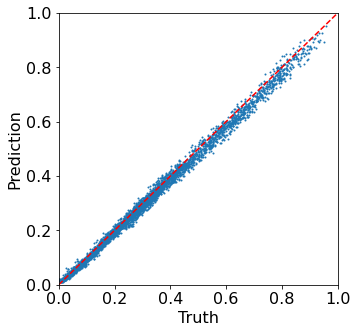

  0%|                                 | 0/626 [00:09<?, ?it/s, val_acc=0.000260]

Got accuracy 0.000260
INFO: Early stopping counter 20 of 20
INFO: Early stopping


In [20]:
stage = 1
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
model.unlock_base()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

In [21]:
torch.save(model.state_dict(), 'TorchModels/Test6_Normalize_HighCs_emitxdefocus_Adam_attempt03.pt')
par.save_result('TorchModels/Test6_Normalize_HighCs_emitxdefocus_Adam_attempt03_')

In [22]:
file = open("TorchModels/Test6_Normalize_HighCs_emitxdefocus_Adam_attempt04_training_log.pkl",'rb')
object_file = pickle.load(file)
file.close()